In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error


In [2]:
np.random.seed(42)

dates = pd.date_range(start="2022-01-01", end="2024-12-31", freq="D")

sales = pd.DataFrame({
    "date": dates,
    "region": np.random.choice(["North", "South", "East", "West"], len(dates)),
    "product": np.random.choice(
        ["Laptop", "Mobile", "Tablet", "Accessory"], len(dates)
    ),
    "units_sold": np.random.poisson(lam=25, size=len(dates)),
    "unit_price": np.random.choice([200, 400, 800, 1200], len(dates))
})

sales["revenue"] = sales["units_sold"] * sales["unit_price"]
sales.head()


,date,region,product,units_sold,unit_price,revenue
0,2022-01-01,East,Mobile,20,200,4000
1,2022-01-02,West,Mobile,29,200,5800
2,2022-01-03,North,Mobile,23,800,18400
3,2022-01-04,East,Tablet,28,200,5600
4,2022-01-05,East,Tablet,30,1200,36000


In [3]:
conn = sqlite3.connect("sales.db")
sales.to_sql("sales_data", conn, index=False, if_exists="replace")

pd.read_sql("SELECT * FROM sales_data LIMIT 5", conn)


,date,region,product,units_sold,unit_price,revenue
0,2022-01-01 00:00:00,East,Mobile,20,200,4000
1,2022-01-02 00:00:00,West,Mobile,29,200,5800
2,2022-01-03 00:00:00,North,Mobile,23,800,18400
3,2022-01-04 00:00:00,East,Tablet,28,200,5600
4,2022-01-05 00:00:00,East,Tablet,30,1200,36000


In [4]:
query = """
SELECT
    strftime('%Y-%m', date) AS month,
    SUM(revenue) AS total_revenue
FROM sales_data
GROUP BY month
ORDER BY month
"""
monthly_revenue = pd.read_sql(query, conn)
monthly_revenue.head()


,month,total_revenue
0,2022-01,558600
1,2022-02,453200
2,2022-03,358800
3,2022-04,419800
4,2022-05,594600


In [5]:
query = """
SELECT region, SUM(revenue) AS revenue
FROM sales_data
GROUP BY region
ORDER BY revenue DESC
"""
region_revenue = pd.read_sql(query, conn)
region_revenue


,region,revenue
0,North,5037600
1,West,4676800
2,East,4395600
3,South,3949400


In [6]:
query = """
SELECT product, SUM(revenue) AS revenue
FROM sales_data
GROUP BY product
ORDER BY revenue DESC
"""
product_revenue = pd.read_sql(query, conn)
product_revenue


,product,revenue
0,Tablet,4860000
1,Mobile,4678000
2,Laptop,4552000
3,Accessory,3969400


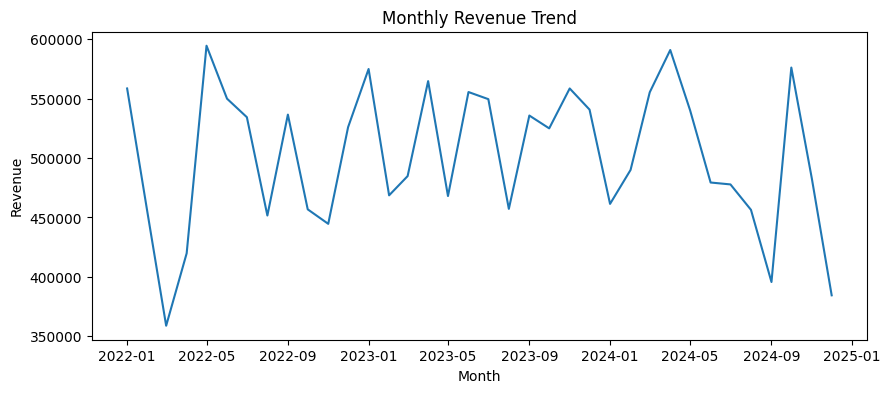

In [7]:
monthly_revenue["month"] = pd.to_datetime(monthly_revenue["month"])

plt.figure(figsize=(10,4))
plt.plot(monthly_revenue["month"], monthly_revenue["total_revenue"])
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()


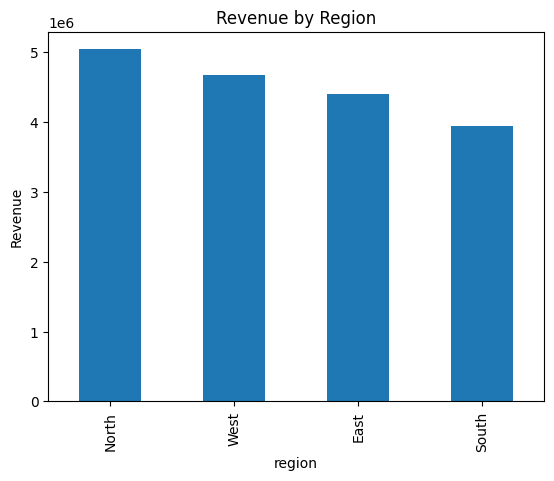

In [8]:
region_revenue.set_index("region").plot(
    kind="bar", legend=False, title="Revenue by Region"
)
plt.ylabel("Revenue")
plt.show()


In [9]:
monthly_revenue.set_index("month", inplace=True)
ts = monthly_revenue["total_revenue"]


In [10]:
model = ARIMA(ts, order=(1,1,1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=6)
forecast


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,predicted_mean
2025-01-01,426778.680029
2025-02-01,435021.962629
2025-03-01,436625.403510
2025-04-01,436937.296573
2025-05-01,436997.964405
2025-06-01,437009.765199


/tmp/ipython-input-3262292751.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(ts.index[-1], periods=7, freq="M")[1:],


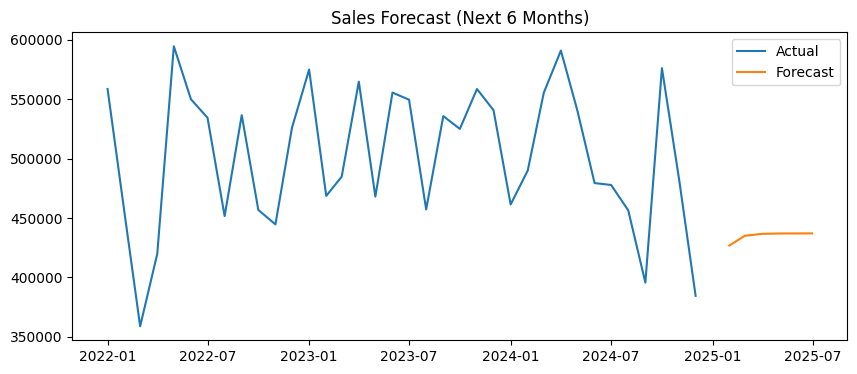

In [11]:
plt.figure(figsize=(10,4))
plt.plot(ts, label="Actual")
plt.plot(
    pd.date_range(ts.index[-1], periods=7, freq="M")[1:],
    forecast,
    label="Forecast"
)
plt.legend()
plt.title("Sales Forecast (Next 6 Months)")
plt.show()


In [12]:
monthly_revenue.reset_index().to_csv("monthly_revenue.csv", index=False)
region_revenue.to_csv("region_revenue.csv", index=False)
product_revenue.to_csv("product_revenue.csv", index=False)
forecast.to_csv("sales_forecast.csv")


In [13]:
from google.colab import files
files.download("monthly_revenue.csv")
files.download("region_revenue.csv")
files.download("product_revenue.csv")
files.download("sales_forecast.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>